E1. Analiza dynamiki wybranej giełdy za pomocą  wybranej techniki teorii grafów 

**Research question: What are correlations between constituents on London stock market?**

Celem tego ćwiczenia jest zbadanie dynamiki wybranej giełdy w okresie narastania wybranej bańki giełdowej oraz  jej pęknięcia, z wykorzystaniem teorii grafów. Realizacja ćwiczenia składa się  z następujących etapów:  

1.  wybór  giełdy  i  ściągnięcie  odpowiednich  empirycznych  danych  giełdowych  z  wybranej  strony internetowej lub uzyskanie ich bezpośrednio z danej giełdy,  
    1. Download FTSE100 historical data from yahoo, transform it into a dataframe and save to a file. 
    2. Plot number of constituents(time) for FTSE100
        1. To do it I should first check the data. Are there any missing values for certain constituents? I can achieve it through finding a start date for each ticker. It can be in a form of a list.
    3. Check is the data complete?
    4. On y axis check does it contains all days except weekends?
    5. For each constituent count how many rows are missing?
2.  Calculate correlations matrix for FTSE100
    1. Create new Stock_values_dataframe with variables that indicate prices.
3.  dobór odpowiedniego modelu sieci oraz algorytmu generującego,  
4.  dobór właściwych przedziałów średniowania,  
5.  dyskusja  uzyskanych  wyników  a  w tym  zwłaszcza  ewentualnych  strukturalnych  topologicznych) przemian fazowych prowadzących do analizy kryzysu i krachu. 

### Questions
    Should I use log transformation?
    How should I calculate <Si> How many days average. (See exercise notes 1.2)
    How to calculate distances between companies? How to interpret them?

[Exercise materials](https://drive.google.com/open?id=0ByG3ASYoU228cnFHaEZDR0tQcWlaZlNGa2xoUEhNSUJfMDg4)

### Notes(Exercise materials)
    1.1 Diferences a couple orders of magnitude
    1.2 <Si> - average over for example 50 days.

### Additional notes
Industrial sectors and constituents

http://www.londonstockexchange.com/exchange/prices-and-markets/stocks/indices/constituents-indices.html?index=MCX&industrySector=&page=2


Historical data for constituents

http://finance.yahoo.com/q?s=CWC.L


all constituents with tickers

http://finance.yahoo.com/q/cp?s=%5EFTSE+Components


In [1]:
import urllib,time,datetime
# import pandas.io.data as web
import pandas as pd
import numpy as np
import pylab as py
import datetime as dt

%matplotlib inline

### 1. A. Below I download FTSE100 historical data from yahoo and save it to data_FTSE100.txt

In [2]:
start = datetime.datetime(1985, 1, 1)
end = datetime.datetime(2015, 4, 29)

constituents_filaname = './constituents_FTSE100'
save_filaname = "./data_FTSE100.txt"

def download_historical_ftse_100(start, end, constituents_filaname, save_filaname):
    
    with open(constituents_filaname) as f:
        lines = f.readlines()
    
    f=web.DataReader(lines[0].strip(), 'yahoo', start, end)
    
    lines = lines[0:100]
    y=[]
    
    for line in lines:
        if len(line.strip())>1:
            try:
                f=web.DataReader(line.strip(), 'yahoo', start, end)
            except:
                raise
            else:
                y.append(f['Open'])             
    
    Stock_values_dataframe = pd.concat(y, axis=1)
    Stock_values_dataframe.columns = [line.replace("\n", "") for line in lines]
    Stock_values_dataframe.to_csv(save_filaname)

## Note
    In 1. A. I downloaded data for FTSE100 and saved it to a file. Below read data from the file. 

In [3]:
Stock_values_dataframe = pd.read_csv( "./ftse_100_time_data.csv" )

print(Stock_values_dataframe[:10])

         Date  AAL.L  ABF.L  ADM.L  ADN.L  AGK.L  AHT.L  ANTO.L  ARM.L  AV.L  \
0  1988-05-03    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN   NaN   
1  1988-05-04    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN   NaN   
2  1988-05-05    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN   NaN   
3  1988-05-06    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN   NaN   
4  1988-05-09    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN   NaN   
5  1988-05-10    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN   NaN   
6  1988-05-11    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN   NaN   
7  1988-05-12    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN   NaN   
8  1988-05-13    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN   NaN   
9  1988-05-16    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN   NaN   

   ...    TSCO.L  TUI.L  TW.L  ULVR.L  UU.L  VOD.L  WEIR.L  WOS.L  WPP.L  \
0  ...       NaN    NaN   NaN     NaN   NaN

### 1. B. Below I calculate number of constituents( time )

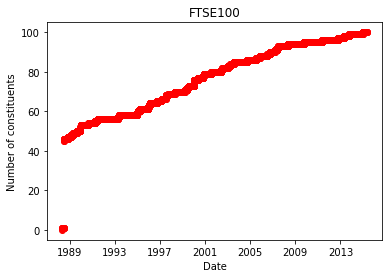

In [4]:
def get_constituents_start_dates(Stock_values_dataframe):
    constituents_tickers = Stock_values_dataframe.columns[1:]
    
    start_dates_constituents_list = []
    
    for constituent_ticker in constituents_tickers:
        for date_index in range(len(Stock_values_dataframe)):
            if Stock_values_dataframe.loc[date_index, constituent_ticker] == Stock_values_dataframe.loc[ 
                date_index, constituent_ticker]:
                start_dates_constituents_list.append(Stock_values_dataframe['Date'][date_index])
                break
                                      
    return start_dates_constituents_list 

def plot_number_of_constituents(Stock_values_dataframe, start_dates_constituents_list):
    number_of_constituents_list = []
        
    for date_index in range(len(Stock_values_dataframe)):
        number_of_constituents = 0
        for start_date in start_dates_constituents_list:
            if Stock_values_dataframe['Date'][date_index] > start_date:
                number_of_constituents += 1
        number_of_constituents_list.append(number_of_constituents)
        
    all_dates = [dt.datetime.strptime(date, '%Y-%m-%d') for date in Stock_values_dataframe['Date'].tolist()]
    
    py.xlabel('Date')
    py.ylabel('Number of constituents')
    py.title('FTSE100')
    
    py.plot(all_dates, number_of_constituents_list, 'ro')
    py.show()
    #fig.savefig('/home/pawel/Documents/magisterka/Financial_historical_data/constituents100.jpg')
    #py.clf()
    
start_dates_constituents_list = get_constituents_start_dates(Stock_values_dataframe)
plot_number_of_constituents(Stock_values_dataframe, start_dates_constituents_list)

### Notes:
- Number of constituents at the beginning is zero because it starts before stock market was opened.

### 1.C. Check completeness of the data. 

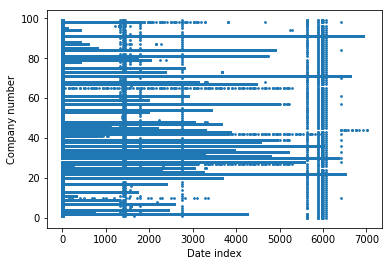

In [6]:
def check_data_completness(Stock_values_dataframe, constituents_tickers):
    fig = py.figure()
    
    already_started = False
    
    x = []
    y = []
    
    for constituent_number in range(len(constituents_tickers)):
        for date_index in range(len(Stock_values_dataframe)):
            if (not already_started) and (Stock_values_dataframe.loc[date_index, 
                                                                        constituents_tickers[ constituent_number]] == 
                    Stock_values_dataframe.loc[date_index, constituents_tickers[constituent_number]]):
                already_started = True
                
            if already_started: 
                if not (Stock_values_dataframe.loc[date_index, constituents_tickers[constituent_number]] == 
                    Stock_values_dataframe.loc[date_index, constituents_tickers[constituent_number]]):
                    #print( "missing value" )
                    x.append(date_index)
                    y.append(constituent_number)
                    
    py.scatter(x, y, s = 3)
    #fig.savefig('~/Dokumenty/education/studia_courses/laboratory_II_degree_physics/missing_data.jpg')
    #py.clf()
    py.xlabel('Date index')
    py.ylabel('Company number')
    py.show()
    
constituents_tickers = Stock_values_dataframe.columns[1:]
            
check_data_completness(Stock_values_dataframe, constituents_tickers)

### Idea
    To merge above I can use:
    result = df1.append(df4)

[How to merge idea here](http://pandas.pydata.org/pandas-docs/stable/merging.html)

    New idea: I can go through every row and compare dates in Stock_values_dataframe and dates_dataframe. If there is na missing data than I can add new row.

### Note
    Dates in Date column in Stock_values_dataframe and dates_dataframe are different.